In [16]:
import numpy as np
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from datetime import datetime
import matplotlib.colors as mcolors
#from itertools import combinations
from scipy.optimize import minimize, rosen, rosen_der
#from scipy.stats import shapiro
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
from statsmodels.tsa.seasonal import seasonal_decompose

import cvxopt as opt
from cvxopt import blas, solvers

# Funções

In [2]:
def calcular_risco(seeds,retornos,horizonte_dias,peso_minimo=0.0):
    """
calcular_risco()

Essa função calcula o risco de uma carteira de investimentos a partir de um conjunto de retornos de ativos e um horizonte de dias desejado.

Parâmetros:
seeds (int): Número de combinações de pesos para a carteira
retornos (DataFrame): Um dataframe contendo os retornos dos ativos
horizonte_dias (int): Número de dias a serem considerados

Retorno:
Um dataframe contendo os pesos, retorno, risco e a relação risco-retorno para cada combinação de pesos gerada.
"""
    resultado = {'pesos':[],'retorno':[],'risco':[],'ratio':[]}
    for n in range(seeds):
        k = np.random.rand(len(retornos.columns))
        w = k / np.sum(k)
        
        # ajustar os pesos se a média for menor que 10%
        if np.min(w) < peso_minimo:
            w[w.argmin()] += (0.1 - w[w.argmin()])
            w[w.argmax()] -= (0.1 - w[w.argmin()])
       
        
        
        retorno_medio = retornos.mean() * horizonte_dias
        retorno_carteira = np.dot(retorno_medio, w)
  

        cov_matrix = retornos.cov()
        risco_carteira = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) * np.sqrt(horizonte_dias)
        ratio = retorno_carteira/risco_carteira #relação risco retorno, ou shape ratio de Markowitz

        resultado['pesos'].append(w)
        resultado['retorno'].append(retorno_carteira)
        resultado['risco'].append(risco_carteira)
        resultado['ratio'].append(ratio)

    return pd.DataFrame(resultado)

In [3]:
def get_ret_vol_sr(weights, retornos):
    # Calcula o retorno anualizado, volatilidade e índice de Sharpe dado os pesos de alocação e os retornos
    weights = np.array(weights)
    ret = np.sum(retornos.mean() * weights) * 12  # Multiplica por 12 para anualizar o retorno
    vol = np.sqrt(np.dot(weights.T, np.dot(retornos.cov(), weights))) * np.sqrt(12)  # Multiplica por sqrt(12) para anualizar a volatilidade
    sr = ret / vol  # Índice de Sharpe é o retorno dividido pela volatilidade
    return np.array([ret, vol, sr])

def check_sum(weights):
    # Retorna 0 se a soma dos pesos for igual a 1 (restrição de alocação total)
    return np.sum(weights) - 1

def minimize_volatility(weights, retornos):
    # Retorna a volatilidade para a otimização de minimização de volatilidade
    return get_ret_vol_sr(weights, retornos)[1]

def maximize_return(weights, retornos):
    # Retorna o retorno negativo para a otimização de maximização de retorno
    return -get_ret_vol_sr(weights, retornos)[0]

def get_frontier(retornos, r_seeds=10000, n_months=12, size_frontier=200,peso_minimo=0.0):
    # Calcula a fronteira eficiente dada uma matriz de retornos de ativos
    resultado = calcular_risco(r_seeds, retornos, n_months)  # Suponho que a função calcular_risco está definida em outro lugar

    num_assets = retornos.shape[1]
    init_guess = np.full(num_assets, 1/num_assets)  # Alocar igualmente inicialmente
    bounds = tuple((peso_minimo, 1) for _ in range(num_assets))  # Limites de alocação de 0 a 1 para cada ativo

    frontier_y = np.linspace(resultado['retorno'].min(), resultado['retorno'].max(), size_frontier)  # Valores de retorno para construir a fronteira
    frontier_x = []

    for possible_return in frontier_y:
        # Definir as restrições para a otimização
        cons = ({'type': 'eq', 'fun': check_sum},  # Restrição de alocação total
                {'type': 'eq', 'fun': lambda wt: get_ret_vol_sr(wt, retornos)[0] - possible_return})  # Restrição de retorno desejado

        # Otimizar para encontrar a volatilidade mínima dada a restrição de retorno desejado
        result = minimize(minimize_volatility, init_guess, args=(retornos,), method='SLSQP', bounds=bounds, constraints=cons)
        frontier_x.append(result.fun)

    return pd.DataFrame({'x': frontier_x, 'y': frontier_y})


# Exploração dos dados

In [4]:
fator_capacidade = pd.read_excel('Geração por fonte.xlsx')
fator_capacidade.describe()

,GSF,GSF flat,Eolica,Solar,Hidrica,horas,FC Eolica,FC Solar,FC Hidrica,G Eolica,Solar.1,Hídrica
count,84.000000,84.000000,84.000000,84.000000,84.000000,83.000000,84.000000,84.000000,84.000000,1.00000,1.00000,1.000000
mean,0.843584,0.812179,0.421241,0.221541,0.423529,730.409639,1.021437,0.974236,1.010995,0.45964,0.25022,-0.232837
std,0.228343,0.108399,0.106405,0.039423,0.060605,19.545467,0.258013,0.173364,0.144670,NaN,NaN,NaN
min,0.483267,0.558449,0.204410,0.045100,0.295628,672.000000,0.495660,0.198329,0.705686,0.45964,0.25022,-0.232837
25%,0.670274,0.735646,0.341570,0.209225,0.372988,720.000000,0.828248,0.920075,0.890351,0.45964,0.25022,-0.232837
50%,0.826012,0.807522,0.412401,0.227400,0.418923,744.000000,1.000000,1.000000,1.000000,0.45964,0.25022,-0.232837
75%,0.972988,0.905066,0.506924,0.240753,0.475537,744.000000,1.229203,1.058720,1.135143,0.45964,0.25022,-0.232837
max,1.625176,0.999375,0.602448,0.297300,0.540768,744.000000,1.460831,1.307388,1.290855,0.45964,0.25022,-0.232837


In [5]:
fator_capacidade['ano'] = fator_capacidade['Data'].dt.year
fator_capacidade['mes'] = fator_capacidade['Data'].dt.month

In [6]:
fator_capacidade['Eolica'] = fator_capacidade["FC Eolica"]/ np.percentile(fator_capacidade["FC Eolica"],50)
fator_capacidade['Solar'] = fator_capacidade["FC Solar"]/ np.percentile(fator_capacidade["FC Solar"],50)
fator_capacidade['Hídrica'] = fator_capacidade["GSF"]/ np.percentile(fator_capacidade["GSF"],50)

In [7]:
fator_capacidade = fator_capacidade[fator_capacidade['ano'] >= 2016]

In [8]:
#condições para tempo umido e seco
condições = [(fator_capacidade['mes'].isin([5,6,7,8,9,10,11])), 
             (fator_capacidade['mes'].isin([12,1,2,3,4]))]

opções = ['seco','úmido']

fator_capacidade['Periodo'] = np.select(condições, opções)
fator_capacidade['base'] = 1
fator_capacidade['úmido'] = np.select(condições, [0,fator_capacidade['Hídrica']])
fator_capacidade['seco'] = np.select(condições, [fator_capacidade['Hídrica'],0])

fator_capacidade['Data'] = pd.to_datetime(fator_capacidade['Data']).dt.strftime('%Y-%m')

#fechar trimestres
condições = [(fator_capacidade['mes'].isin([3,6,9,12])), 
             (fator_capacidade['mes'].isin([1,2,4,5,7,8,10,11,3,9]))]

opções = [fator_capacidade['Data'],'']

fator_capacidade['Trimestres'] = np.select(condições, opções)

fator_capacidade.reset_index(drop=True,inplace=True)


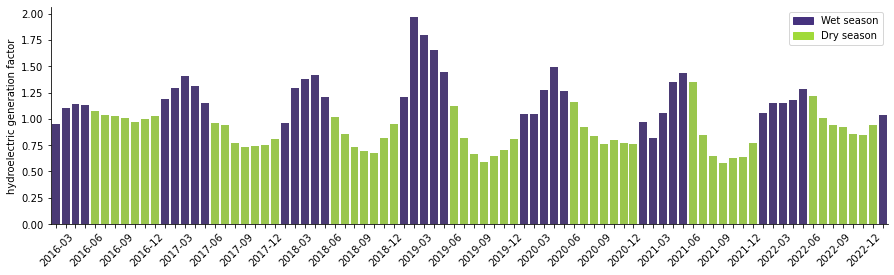

In [9]:
fig, ax = plt.subplots(figsize=(15,4))
viridis_pal = sns.color_palette("viridis")
sns.despine(ax=ax, right=True, top=True)

sns.barplot(data=fator_capacidade, y='úmido', x='Data',color=viridis_pal[0], ax=ax)
sns.barplot(data=fator_capacidade, y='seco', x='Data',color=viridis_pal[5], ax=ax)
ax.set_xticklabels(labels=fator_capacidade['Trimestres'], rotation=45, ha='right')

ax.set_ylabel('hydroelectric generation factor') #hydroelectric generation factor
ax.set_xlabel('')

# Cria os objetos Patch para as cores
patches = [Patch(color=viridis_pal[0], label='Wet season'),Patch(color=viridis_pal[5], label='Dry season')] #Periodo seco e Periodo úmido


# Adiciona a legenda com os objetos Patch
ax.legend(handles=patches)


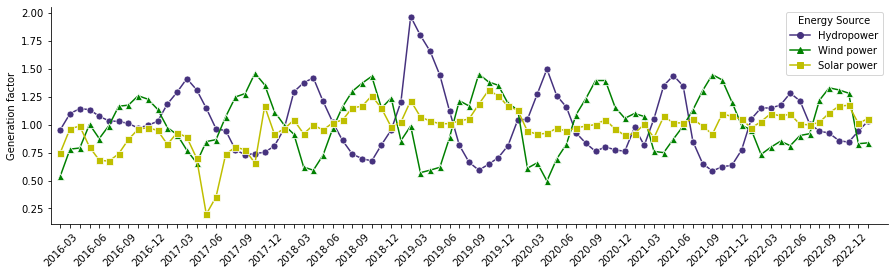

,Eolica,Solar,Hídrica
count,84.000000,84.000000,84.000000
mean,1.021437,0.974236,1.021273
std,0.258013,0.173364,0.276440
min,0.495660,0.198329,0.585060
25%,0.828248,0.920075,0.811458
50%,1.000000,1.000000,1.000000
75%,1.229203,1.058720,1.177934
max,1.460831,1.307388,1.967496


In [10]:
plt.figure(figsize=(15, 4))

# Define os marcadores na legenda
legend_elements = [
    Line2D([0], [0], color=viridis_pal[0], marker='o', label='Hydropower'),
    Line2D([0], [0], color='g', marker='^', label='Wind power'),
    Line2D([0], [0], color='y', marker='s', label='Solar power')
]

# Usa a coluna 'idx' como eixo x
fig = sns.lineplot(data=fator_capacidade[['Hídrica', 'Eolica', 'Solar']],
                   palette=(viridis_pal[0],"g","y"),
                   markers=['o', '^', 's'],
                   dashes=False,
                   linewidth=1.5,  # Largura da linha
                   markersize=7  # Tamanho dos marcadores
                   )

# Remove as bordas direita e superior do gráfico
sns.despine(right=True, top=True)

# Define os rótulos do eixo x como as datas
plt.xticks(range(len(fator_capacidade)), fator_capacidade['Trimestres'], rotation=45, ha='right')
fig.set_ylabel('Generation factor') # Fator de geração

# Adiciona a legenda com os objetos Line2D e define o título
plt.legend(handles=legend_elements, title='Energy Source')

fig.set_xlim(-1, len(fator_capacidade) + 1)
plt.show()

fator_capacidade[['Eolica', 'Solar', 'Hídrica']].describe()



In [11]:
#Filtrar o periodo para a partir de 2016

preços = pd.read_excel("PLD.xlsx")
preços = preços[preços['Data'].dt.year >= 2016]
preços['mes'] = preços['Data'].dt.month
preços['Data'] = pd.to_datetime(preços['Data']).dt.strftime('%Y-%m')


In [12]:
#fechar trimestres
condições = [(preços['mes'].isin([3,6,9,12])), 
             (preços['mes'].isin([1,2,4,5,7,8,10,11,3,9]))]

opções = [preços['Data'],'']

preços['Trimestres'] = np.select(condições, opções)
preços.reset_index(drop=True,inplace=True)

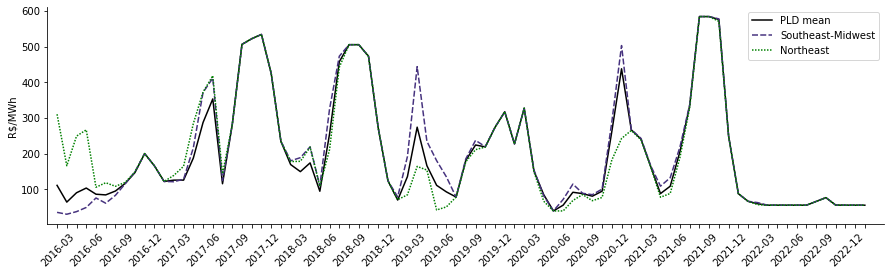

In [13]:
fig, ax = plt.subplots(figsize=(15,4))

# Usa a coluna 'idx' como eixo x
sns.lineplot(ax=ax,data=preços[['Total','SE/CO - SUDESTE','NE - NORDESTE']],palette=['black',viridis_pal[0],"g"], dashes=True)

# Remove as bordas direita e superior do gráfico
sns.despine(ax=ax, right=True, top=True)

# Define os rótulos do eixo x como as datas
plt.xticks(range(len(preços)), preços['Trimestres'],rotation=45, ha='right')

#lable y
ax.set_ylabel('R$/MWh')

# Cria os objetos Patch para as cores
patches = [Patch(color=viridis_pal[0], label='Southeast'),Patch(color="g", label='Northeast'),Patch(color='black', label='PLD médio')]

# Adiciona a legenda com os objetos Patch
ax.legend(labels=['PLD mean','Southeast-Midwest','Northeast'])

ax.set_xlim(-1,len(preços)+1)

plt.show()

<AxesSubplot:>

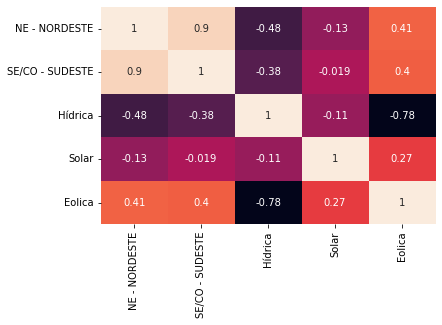

In [14]:
#Correlação entre as variáveis
df_exposição = pd.merge(fator_capacidade[['Data','Hídrica','Solar','Eolica']],
                    preços[['Data','NE - NORDESTE','SE/CO - SUDESTE','Total']])

sns.heatmap(df_exposição[['NE - NORDESTE','SE/CO - SUDESTE','Hídrica','Solar','Eolica']].corr(),cbar=False,annot=True)

In [15]:
#exposição por cada MWm contratado, assumindo que todos os meses tenha 30 dias
horas = fator_capacidade['horas']

df_exposição['exp hidrica'] = (1-df_exposição['Hídrica']) * df_exposição['SE/CO - SUDESTE'] * horas
df_exposição['exp eolica'] = (1-df_exposição['Eolica'])* df_exposição['NE - NORDESTE'] * horas
df_exposição['exp solar'] = (1-df_exposição['Solar']) *  df_exposição['Total'] * horas

df_exposição.head()

,Data,Hídrica,Solar,Eolica,NE - NORDESTE,SE/CO - SUDESTE,Total,exp hidrica,exp eolica,exp solar
0,2016-01,0.954742,0.749780,0.540360,310.38,35.66,111.2850,1200.748207,106141.268809,20717.214934
1,2016-02,1.099098,0.964380,0.781081,166.28,30.42,64.3850,-2098.139586,25335.702512,1596.204380
2,2016-03,1.143618,0.986807,0.790993,249.11,37.73,90.5750,-4031.527220,38736.974862,889.021108
3,2016-04,1.134425,0.799912,1.002976,266.71,49.42,103.7525,-4783.147798,-571.567214,14946.930079
4,2016-05,1.075803,0.682498,0.875506,106.07,75.93,86.4725,-4282.258025,9824.550227,20426.675409


In [16]:
ROL = 200 * np.array([horas,horas,horas]).T * np.array([0.8985, 0.9635, 0.9635])
exposição = df_exposição[['exp hidrica','exp eolica','exp solar']] * np.array([0.9075,1,1])

margem = ROL + exposição
margem.columns = ['margem hidrica','margem eolica','margem solar']
margem.dropna(inplace=True)

,margem hidrica,margem eolica,margem solar
count,83.000000,83.000000,83.000000
mean,139653.425288,125607.154607,144651.533164
std,55463.564503,55635.591494,38451.558222
min,-95305.267119,-51189.834235,50541.793931
25%,120866.681616,115052.990886,135756.250211
50%,132334.118296,137052.994164,142045.654354
75%,165403.640128,151753.414569,150121.504644
max,297276.202777,249510.068809,313279.971768


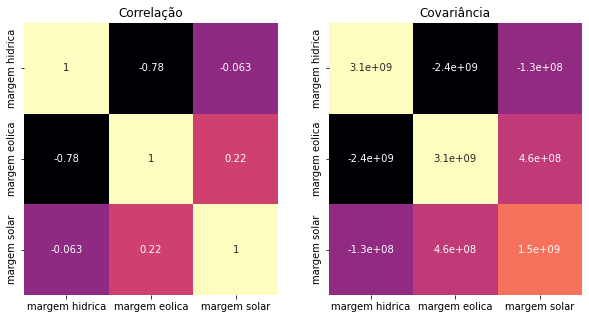

In [17]:
#Correlação entre as margens calculadas
f, axes = plt.subplots(1, 2, figsize = (10,5))

sns.heatmap(margem.corr(),cbar=False,annot=True,cmap="magma",ax=axes[0]).set_title('Correlação')
sns.heatmap(margem.cov(),cbar=False,annot=True,cmap="magma",ax=axes[1]).set_title('Covariância')

margem.describe()

# Modelagem - Markowitz

<AxesSubplot:xlabel='retorno', ylabel='Count'>

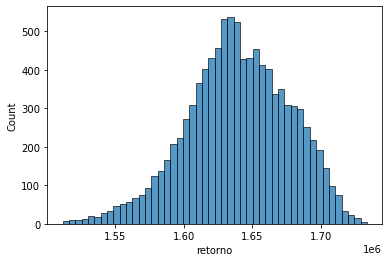

In [18]:
#Distribuição entre os retornos esperados
seeds = 10000
horizonte_meses = 12
resultado = calcular_risco(seeds,margem,horizonte_meses)
sns.histplot(resultado['retorno'])

In [19]:
best_ratio = resultado.sort_values('ratio',ignore_index=True,ascending=False).head(1)

best_ratio_w = pd.DataFrame([list(best_ratio['pesos'][0].round(2))],
                            columns=['Hydropower  ','  Wind power  ','  Solar power'])

best_w = list(best_ratio['pesos'][0])
     
frontier = get_frontier(margem,size_frontier=80)

In [20]:
result_asis = get_ret_vol_sr([.75,.2,.05],margem)
result_hidr = get_ret_vol_sr([1,0,0],margem)
result_eol = get_ret_vol_sr([0,1,0],margem)
result_sol = get_ret_vol_sr([0,0,1],margem)

result_teo_1 = get_ret_vol_sr([.33,.33,.33],margem)
result_teo_2 = get_ret_vol_sr([.5,0,.5],margem)
result_teo_3 = get_ret_vol_sr([.5,.5,0],margem)
result_teo_4 = get_ret_vol_sr([0,.5,.5],margem)

C:\Users\caiozas\AppData\Local\Temp\ipykernel_3408\2650728693.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
C:\Users\caiozas\AppData\Local\Temp\ipykernel_3408\2650728693.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


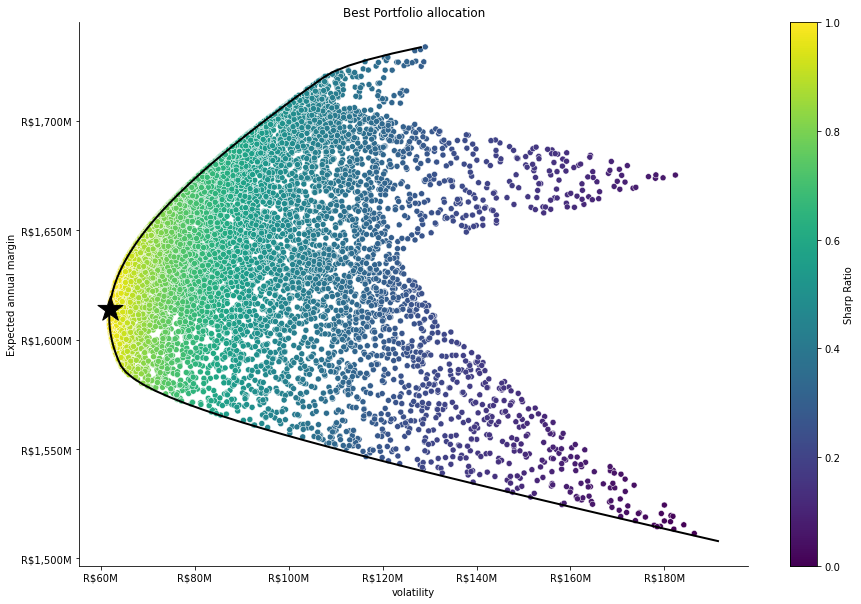

In [45]:
plt.figure(figsize=(15,10))
g = sns.scatterplot(data=resultado,x='risco',y='retorno',palette='viridis',hue='ratio',legend=False)
plt.plot(frontier['x'], frontier['y'], 'black', linewidth=2)
plt.scatter(best_ratio['risco'], best_ratio['retorno'], color='black', s=700, marker="*", zorder=10)

#plt.scatter(result_asis[1], result_asis[0],color='black',s=300,marker="d")
#plt.scatter(result_teo_1[1], result_teo_1[0],color='black',s=300,marker="s")

#100% cada uma das fontes
#plt.scatter(result_hidr[1], result_hidr[0],color='b',s=500,marker="x")
#plt.scatter(result_eol[1], result_eol[0],color='g',s=500,marker="x")
#plt.scatter(result_sol[1], result_sol[0],color='y',s=500,marker="x")


plt.colorbar(label='Sharp Ratio')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('volatility')
plt.ylabel('Expected annual margin')
plt.title("Best Portfolio allocation")

#plt.annotate(f'Best Portfolio allocation:\n\n Hydropower   Wind power   Solar power  \n        {int(best_w[0]*100)}%             {int(best_w[1]*100)}%                {int(best_w[2]*100)}%  ', xy=(0.7, 0.5), xycoords='axes fraction')

# Remove as bordas direita e superior do gráfico
sns.despine(right=True, top=True)

xlabels = ['R${:,.0f}M'.format(x) for x in g.get_xticks()/10**3]
ylabels = ['R${:,.0f}M'.format(x) for x in g.get_yticks()/10**3]
g.set_xticklabels(xlabels)
g.set_yticklabels(ylabels)
print()

In [22]:
margem_opt = margem

In [23]:
# Multiplicamos cada linha do DataFrame pelo vetor de pesos usando np.dot
margem_opt['Portfolio'] = np.dot(margem_opt.iloc[:, :3].values, best_ratio_w.values.flatten())
margem = margem[['margem hidrica','margem eolica','margem solar']]

Text(0, 0.5, 'Generation factor')

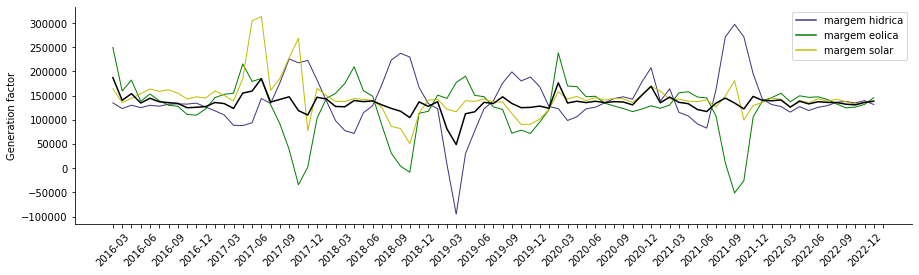

In [24]:
plt.figure(figsize=(15, 4))

# Usa a coluna 'idx' como eixo x
fig = sns.lineplot(data=margem_opt.iloc[:, :3],
                   palette=(viridis_pal[0],"g","y"),
                   dashes=False,
                   linewidth=1,  # Largura da linha
                   )
# Usa a coluna 'idx' como eixo x
fig = sns.lineplot(data=margem_opt['Portfolio'],
                   color='black',
                   dashes=True,
                   linewidth=1.5,  # Largura da linha
                   markersize=7  # Tamanho dos marcadores
                   )

# Remove as bordas direita e superior do gráfico
sns.despine(right=True, top=True)

# Define os rótulos do eixo x como as datas
plt.xticks(range(len(fator_capacidade)), fator_capacidade['Trimestres'], rotation=45, ha='right')
fig.set_ylabel('Generation factor') # Fator de geração

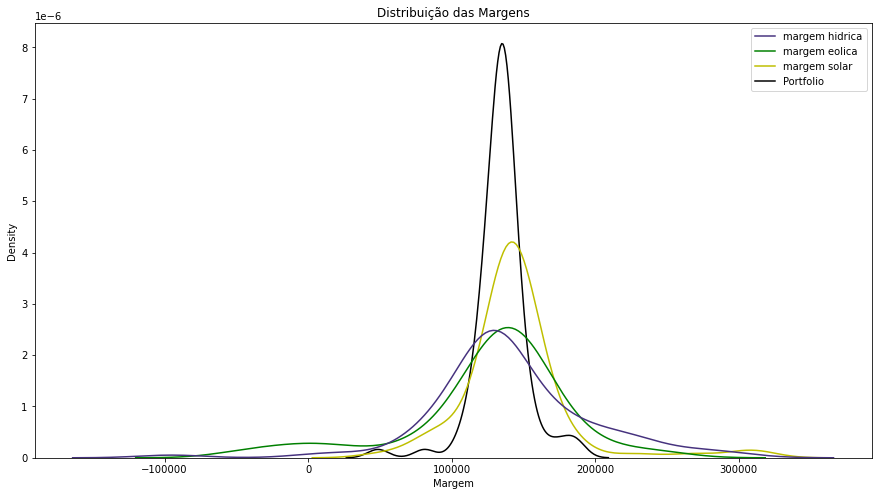

In [25]:

# Kernel de comparativos fontes individuais vs portfolio
plt.figure(figsize=(15, 8))

sns.kdeplot(data=margem_opt,
                palette=(viridis_pal[0],"g","y",'black'))

# Defina o título do gráfico
plt.title('Distribuição das Margens')
plt.xlabel('Margem')

# Exiba o gráfico
plt.show()

In [26]:
seeds = 1000
horizonte_meses = 12
retultado_hidro_solar = calcular_risco(seeds,margem[['margem hidrica','margem solar']],horizonte_meses)
retultado_hidro_eol = calcular_risco(seeds,margem[['margem hidrica','margem eolica']],horizonte_meses)
retultado_eol_solar = calcular_risco(seeds,margem[['margem eolica','margem solar']],horizonte_meses)
frontier_hidro_solar = get_frontier(margem[['margem hidrica','margem solar']],size_frontier=80)
frontier_hidro_eol = get_frontier(margem[['margem hidrica','margem eolica']],size_frontier=80)
frontier_eol_solar = get_frontier(margem[['margem eolica','margem solar']],size_frontier=80)

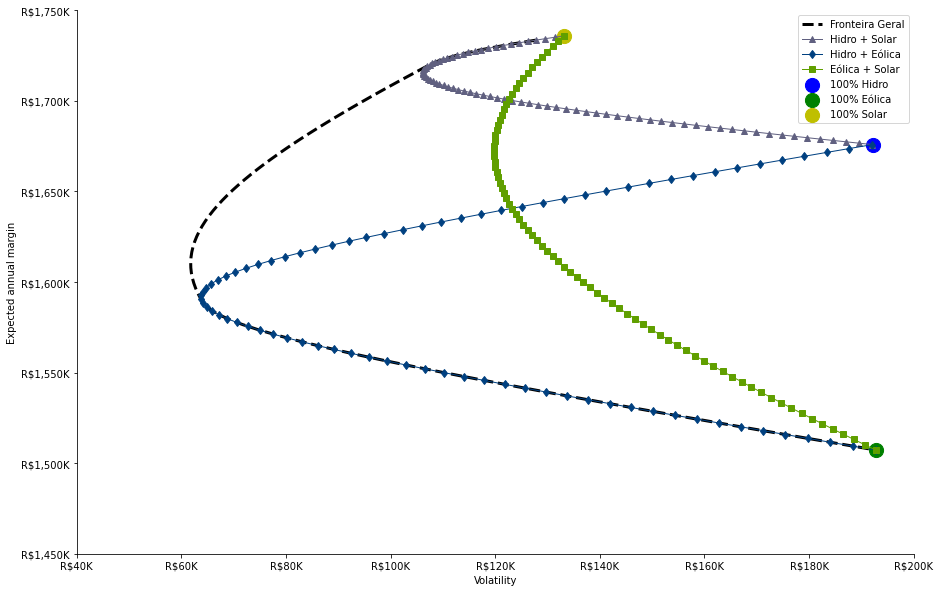

In [27]:

# Função para calcular a cor intermediária entre duas cores em formato RGB
def color_blend(color1, color2):
    rgba1 = mcolors.to_rgba(color1)
    rgba2 = mcolors.to_rgba(color2)
    return [(c1 + c2) / 2 for c1, c2 in zip(rgba1, rgba2)]

# Aqui você teria as variáveis frontier_hidro_solar, frontier_hidro_eol e frontier_eol_solar já calculadas

# Cores das fontes
color_hidro = 'b'
color_eol = 'g'
color_solar = 'y'

# Cores intermediárias para as combinações
color_hidro_solar = color_blend(color_hidro, color_solar)
color_hidro_eol = color_blend(color_hidro, color_eol)
color_eol_solar = color_blend(color_eol, color_solar)

# Plot das fronteiras eficientes
plt.figure(figsize=(15, 10))
plt.plot(frontier['x'], frontier['y'], 'black', linewidth=3, label='Fronteira Geral',linestyle='dashed')
plt.plot(frontier_hidro_solar['x'], frontier_hidro_solar['y'], color=color_hidro_solar, linewidth=1, label='Hidro + Solar',marker='^')
plt.plot(frontier_hidro_eol['x'], frontier_hidro_eol['y'], color=color_hidro_eol, linewidth=1, label='Hidro + Eólica',marker='d')
plt.plot(frontier_eol_solar['x'], frontier_eol_solar['y'], color=color_eol_solar, linewidth=1, label='Eólica + Solar',marker='s')

# 100% de cada uma das fontes
plt.scatter(result_hidr[1], result_hidr[0], color=color_hidro, s=200, marker="o", label='100% Hidro')
plt.scatter(result_eol[1], result_eol[0], color=color_eol, s=200, marker="o", label='100% Eólica')
plt.scatter(result_sol[1], result_sol[0], color=color_solar, s=200, marker="o", label='100% Solar')

plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Volatility')
plt.ylabel('Expected annual margin')
plt.legend()

# Remove as bordas direita e superior do gráfico
sns.despine(right=True, top=True)

xlabels = ['R${:,.0f}K'.format(x) for x in plt.xticks()[0]/10**3]
ylabels = ['R${:,.0f}K'.format(x) for x in plt.yticks()[0]/10**3]
plt.xticks(plt.xticks()[0], xlabels)
plt.yticks(plt.yticks()[0], ylabels)
#g = sns.scatterplot(data=resultado,x='risco',y='retorno',legend=False,color=(0.7, 0.7, 0.7))
plt.show()



In [28]:
result_asis = get_ret_vol_sr([.75,.2,.05],margem)
frontier_2 = get_frontier(margem,size_frontier=80,peso_minimo=0.00)
frontier_4 = get_frontier(margem,size_frontier=80,peso_minimo=0.05)

init_guess = [.33,.33,.34]
bounds = ((0,1),(0,1),(0,1))

cons2 = ({'type':'eq', 'fun':check_sum},
         {'type':'eq', 'fun': lambda wt: get_ret_vol_sr(wt,margem)[0] - result_asis[0]})

result_2 = minimize(minimize_volatility,init_guess,args=(margem,),method='SLSQP', bounds=bounds, constraints=cons2)


cons3 = ({'type':'eq', 'fun':check_sum},
         {'type':'eq', 'fun': lambda wt: get_ret_vol_sr(wt,margem)[1] - result_asis[1]},
         )

result_3 = minimize(maximize_return,init_guess,args=(margem,),method='SLSQP', bounds=bounds, constraints=cons3)

result_2_w = pd.DataFrame([result_2['x'].round(2)],
                            columns=['hídrica','eolica','solar'])
result_3_w = pd.DataFrame([result_3['x'].round(2)],
                            columns=['hídrica','eolica','solar'])


atual_w = pd.DataFrame([[.75,.2,.05]],
                            columns=['hídrica','eolica','solar'])

C:\Users\caiozas\Anaconda39\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


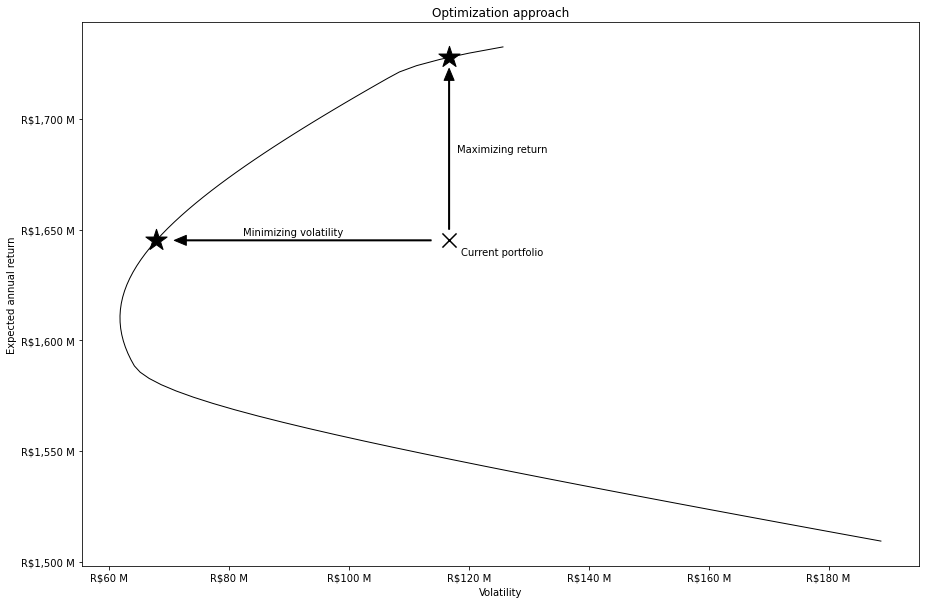

In [47]:
plt.figure(figsize=(15,10))
plt.scatter(result_asis[1], result_asis[0],color='black',s=200,marker="x")
plt.scatter(result_2['fun'], result_asis[0],color='black',s=500,marker="*")
plt.scatter(result_asis[1],-result_3['fun'],color='black',s=500,marker="*")
plt.plot(frontier_2['x'],frontier_2['y'], 'black', linewidth=1)
#plt.plot(frontier_4['x'],frontier_4['y'], 'black', linewidth=1)

plt.title("Optimization approach")

plt.xlabel('Volatility')
plt.ylabel('Expected annual return')

# Formatação dos eixos x e y
formatter = mtick.FuncFormatter(lambda x, _: f'R${x/1000:,.0f} M')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Anotação dos pontos X
plt.annotate(f'Current portfolio \n ' #{atual_w}
             ,(result_asis[1], result_asis[0])
             , xytext=(result_asis[1]+2000, result_asis[0]-12000)
            )


# Anotação da seta de minimização de volatilidade
arrow_start = (result_asis[1]-3000, result_asis[0])
arrow_end = (result_2['fun']+3000, result_asis[0])
arrow_midpoint = ((arrow_start[0]+arrow_end[0])/2-10000, arrow_start[1]+2500)

plt.annotate('', xy=arrow_end, xytext=arrow_start,
            arrowprops={'facecolor':'black', 'width':1, 'headwidth':10})

plt.annotate('Minimizing volatility', xy=arrow_midpoint)

#plt.annotate(f'Portifólio volatilidade minimizada \n {result_2_w}', 
#             (result_2['fun'], result_asis[0]), xytext=(result_2['fun'], result_asis[0]-25000))


# Anotação da seta de maximização de resultado
arrow_start_max = (result_asis[1], result_asis[0]+5000)
arrow_end_max = (result_asis[1],-result_3['fun']-5000)

plt.annotate('', xy=arrow_end_max, xytext=arrow_start_max,
             arrowprops={'facecolor':'black', 'width':1, 'headwidth':10})

plt.annotate('Maximizing return', xy=(118000,1685000))

#plt.annotate(f'Portifólio retorno maximizado \n {result_3_w}', 
#             (result_asis[1],-result_3['fun']-10000), xytext=(result_asis[1]+3000,-result_3['fun']-20000))



print()


# Avaliação do modelo - Monte Carlo

,P,Margem,Desvio
0,1,R$54 mil,-61%
1,5,R$83 mil,-40%
2,25,R$120 mil,-13%
3,50,R$138 mil,0%
4,75,R$154 mil,11%
5,95,R$184 mil,34%
6,99,R$213 mil,55%


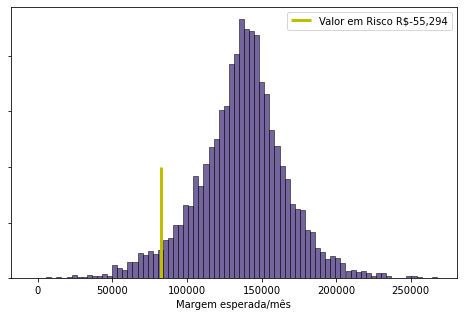

In [30]:
#parametros___________________________________________________________________________

seeds = 10000
horizonte_meses = 12
w_best = resultado['pesos'][resultado[resultado['ratio'] == resultado['ratio'].max()].index[0]]
w_worst = resultado['pesos'][resultado[resultado['ratio'] == resultado['ratio'].min()].index[0]]
w_asis = [0,.5,.5]


#simulador___________________________________________________________________________

df_exposição2 = df_exposição[['Hídrica','Eolica','Solar','SE/CO - SUDESTE','NE - NORDESTE']]

min_vals = np.array(df_exposição2.min())-.1
max_vals = np.array(df_exposição2.max())+.1

dist_norm = np.random.multivariate_normal(df_exposição2.mean(),df_exposição2.cov(),seeds)


mask = np.all((dist_norm >= min_vals) & (dist_norm <= max_vals), axis=1)
dist_norm = dist_norm[mask].T


#exposição por cada MWm contratado, assumindo que todos os meses tenha 30 dias

sim_expo = np.array([(dist_norm[0]-1) * (dist_norm[3]* 24 * 30), #hídrica
                     (dist_norm[1]-1 )* (dist_norm[4] * 24 * 30), #eólica
                     (dist_norm[2]-1) *  (dist_norm[3] * 24 * 30) #solar
                    ]).T * np.array([0.8985,1,1]) #PIS e COFINS

sim_ROL = (200 * 24 * 30) * np.array([0.8985,0.9635,0.9635])

sim_margem = np.dot(sim_ROL - sim_expo,w_asis)

    
plt.figure(figsize=(8,5))

media = np.mean(sim_margem)
P5 = np.percentile(sim_margem,5)
P50 = np.percentile(sim_margem,50)
plt.vlines(x=P5,ymin=0,ymax=200,
           colors = 'y',linewidth=3,
           label='Valor em Risco R${:,.0f}'.format(P5-P50))
ax = sns.histplot(sim_margem,color=sns.color_palette("viridis")[0])
ax.set_yticklabels('')
ax.set(ylabel='')

plt.xlabel('Margem esperada/mês')

plt.legend()

percentis = [1,5,25,50,75,95,99]

pd.DataFrame({"P":percentis,
              'Margem':np.percentile(sim_margem,percentis)/10**3,
              'Desvio':np.percentile(sim_margem,percentis)/np.percentile(sim_margem,50) - 1 }
            ).style.format({'Margem':'R${:,.0F} mil',
                            'Margem total mês':'R${:,.0F} milhões',
                            'Margem total ano':'R${:,.0F} milhões',
                            'Desvio':'{:.0%}'})



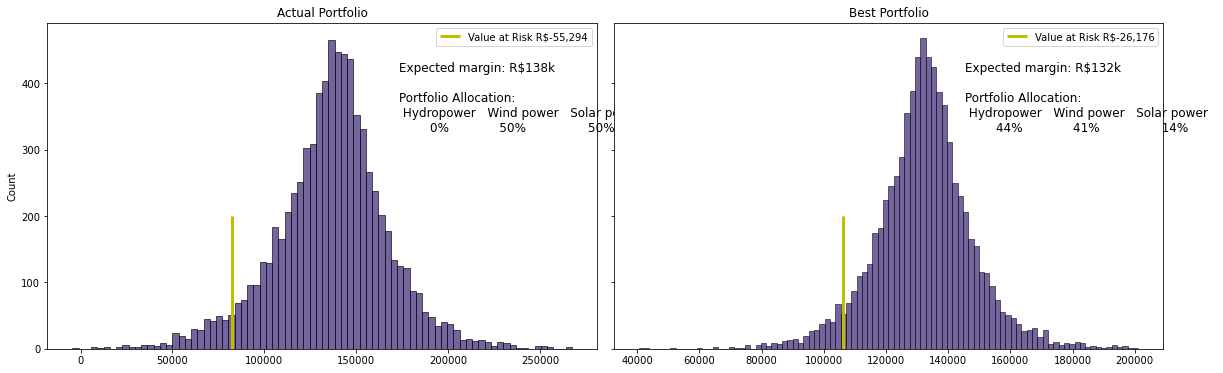

In [31]:
sim_margem = [np.dot(sim_ROL - sim_expo,w) for w in [w_asis, w_best, w_worst,[1,0,0],[0,1,0],[0,0,1]]]

# Criando os subplots
fig, axs = plt.subplots(1,2, figsize=(20, 6), sharey=True)
fig.subplots_adjust(wspace=0.03)
pesos = [w_asis, w_best, w_worst]
# Loop pelos subplots
for i, ax in enumerate(axs.flat):
        # Plot dos 3 cenários na primeira linha
        margem = sim_margem[i]
        media = np.mean(margem)
        P5 = np.percentile(margem, 5)
        P50 = np.percentile(margem, 50)
        ax.vlines(x=P5, ymin=0, ymax=200,
                   colors='y', linewidth=3,
                   label='Value at Risk R${:,.0f}'.format(P5-P50))
        ax = sns.histplot(margem, color=sns.color_palette("viridis")[0], ax=ax)
        #ax.set_yticklabels('')
        #ax.set_ylim([0, 25])
        #ax.set(xlabel='', ylabel='')
        ax.set_title(f'{["Actual", "Best", "Worst"][i]} Portfolio')
        ax.text(0.64, 0.88, f'Expected margin: R${P50/1000:,.0f}k\n\nPortfolio Allocation:\n Hydropower   Wind power   Solar power  \n        {int(pesos[i][0]*100)}%             {int(pesos[i][1]*100)}%                {int(pesos[i][2]*100)}%  ', transform=ax.transAxes,
            fontsize=12, verticalalignment='top')
        ax.legend()


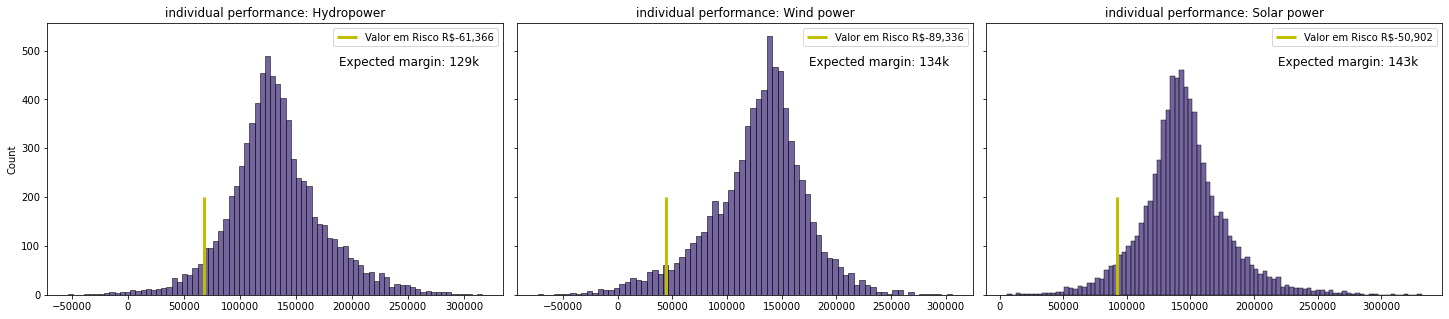

In [32]:
# Criando os subplots
fig, axs = plt.subplots(1,3, figsize=(25, 5), sharey=True)
fig.subplots_adjust(wspace=0.03)
for i, ax in enumerate(axs.flat):
        margem = sim_margem[i+3]
        media = np.mean(margem)
        P5 = np.percentile(margem, 5)
        P50 = np.percentile(margem, 50)
        ax.vlines(x=P5, ymin=0, ymax=200,
                   colors='y', linewidth=3,
                   label='Valor em Risco R${:,.0f}'.format(P5-P50))
        ax = sns.histplot(margem, color=sns.color_palette("viridis")[0], ax=ax)
        #ax.set_yticklabels('')
        #ax.set(xlabel='', ylabel='')
        ax.set_title(f'individual performance: {["Hydropower", "Wind power", "Solar power"][i-3]}')
        ax.text(0.64, 0.88, f'Expected margin: {P50/1000:.0f}k', transform=ax.transAxes,
                fontsize=12, verticalalignment='top')
        ax.legend()

plt.show()

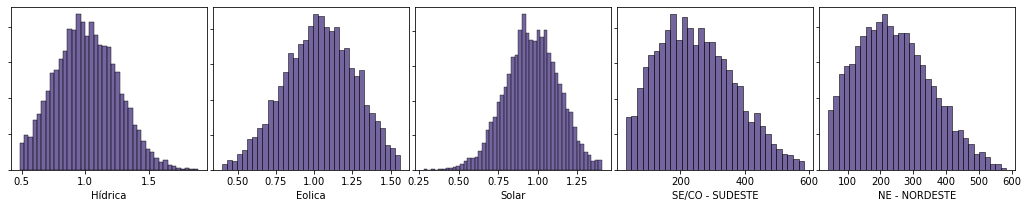

In [33]:
data = pd.DataFrame(dist_norm.T, columns=df_exposição2.columns)
f, axes = plt.subplots(1,5, figsize = (18,3))
f.subplots_adjust(wspace=0.03)

n=0
for serie in data.columns:
    sns.histplot(data[serie],color=sns.color_palette("viridis")[0],ax=axes[n]).set(yticklabels=[],ylabel=None)
    n+=1

In [34]:
variaveis = ['Hídrica', 'Eolica', 'Solar', 'SE/CO - SUDESTE', 'NE - NORDESTE']

# Simulação de exposição, ROL e margem
def simulate_margins(df, variaveis, seed=10000):
    df_exposicao2 = df[variaveis]

    min_vals = np.array(df_exposicao2.min()) - 0.1
    max_vals = np.array(df_exposicao2.max()) + 0.1

    dist_norm = np.random.multivariate_normal(df_exposicao2.mean(), df_exposicao2.cov(), size=seed)

    mask = np.all((dist_norm >= min_vals) & (dist_norm <= max_vals), axis=1)
    dist_norm = dist_norm[mask].T

    sim_expo = np.array([(dist_norm[0] - 1) * (dist_norm[3] * 24 * 30),
                         (dist_norm[1] - 1) * (dist_norm[4] * 24 * 30),
                         (dist_norm[2] - 1) * (dist_norm[3] * 24 * 30)
                         ]).T * np.array([0.8985, 1, 1])

    sim_ROL = (200 * 24 * 30) * np.array([0.8985, 0.9635, 0.9635])

    sim_margem = sim_ROL - sim_expo

    media = np.mean(sim_margem)
    P5 = np.percentile(sim_margem, 5)
    P50 = np.percentile(sim_margem, 50)

    return media, P5, P50

In [35]:
# Realizar a simulação de margens
media, P5, P50 = simulate_margins(df_exposição2, variaveis)

# Realizar a análise de sensibilidade
sensitivity_results = []
for var in variaveis:
    perturbed_df = df_exposição2.copy()
    perturbed_df[var] = np.random.permutation(perturbed_df[var])
    perturbed_media, perturbed_P5, perturbed_P50 = simulate_margins(perturbed_df, variaveis)
    sensitivity_results.append({
        'Variável': var,
        'Média': perturbed_media,
        'Percentil 5': perturbed_P5,
        'Percentil 50': perturbed_P50
    })
    
# Criar um DataFrame com os resultados de sensibilidade
sensitivity_df = pd.DataFrame(sensitivity_results)

In [36]:
# Função para calcular o V@R
def calculate_VAR(df, variaveis, seed=10000):
    media_original, P5_original, P50_original = simulate_margins(df, variaveis, seed)
    return media_original, P5_original, P50_original

# Função para realizar análise de sensibilidade
def sensitivity_analysis(df, variaveis, variable_index, seed=10000):
    original_media, original_P5, original_P50 = calculate_VAR(df, variaveis, seed)
    
    variable_range = np.linspace(0.8, 1.2, num=11)  # Range de variação da variável (80% a 120%)
    results = []
    
    for factor in variable_range:
        modified_df = df.copy()
        modified_df[variaveis[variable_index]] *= factor
        
        modified_media, modified_P5, modified_P50 = calculate_VAR(modified_df, variaveis, seed)
        
        impact_on_media = ((modified_media - original_media) / original_media) * 100
        impact_on_P5 = ((modified_P5 - original_P5) / original_P5) * 100
        impact_on_P50 = ((modified_P50 - original_P50) / original_P50) * 100
        
        results.append((factor, impact_on_media, impact_on_P5, impact_on_P50))
    
    return results

# Realizando a análise de sensibilidade para cada variável
for i, variable in enumerate(variaveis):
    sensitivity_results = sensitivity_analysis(df_exposição2, variaveis, i)
    
    print(f"Análise de Sensibilidade para a variável: {variable}")
    print("{:<10} {:<20} {:<20} {:<20}".format("Fator", "Impacto na Média (%)", "Impacto no P5 (%)", "Impacto no P50 (%)"))
    print("="*60)
    for result in sensitivity_results:
        factor, impact_on_media, impact_on_P5, impact_on_P50 = result
        print("{:<10.2f} {:<20.2f} {:<20.2f} {:<20.2f}".format(factor, impact_on_media, impact_on_P5, impact_on_P50))
    print("\n")


Análise de Sensibilidade para a variável: Hídrica
Fator      Impacto na Média (%) Impacto no P5 (%)    Impacto no P50 (%)  
0.80       8.17                 13.33                5.78                
0.84       6.30                 14.84                4.41                
0.88       4.80                 11.07                3.25                
0.92       3.44                 10.17                2.25                
0.96       1.70                 2.66                 1.26                
1.00       0.36                 0.39                 0.38                
1.04       -1.34                -6.35                -0.63               
1.08       -2.70                -12.18               -1.68               
1.12       -4.45                -21.25               -2.81               
1.16       -6.11                -30.80               -3.63               
1.20       -7.68                -36.85               -4.64               


Análise de Sensibilidade para a variável: Eolica
Fator      

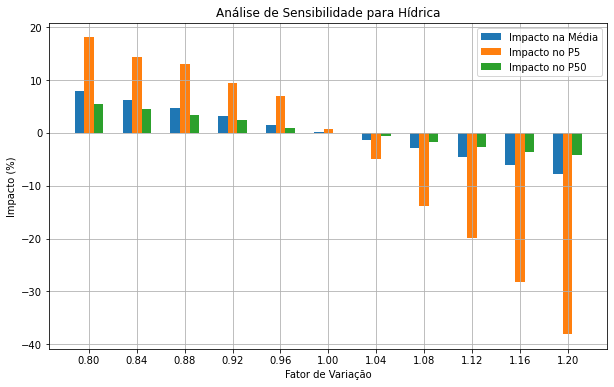

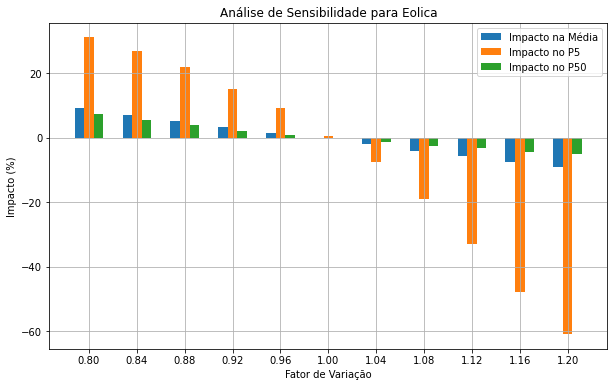

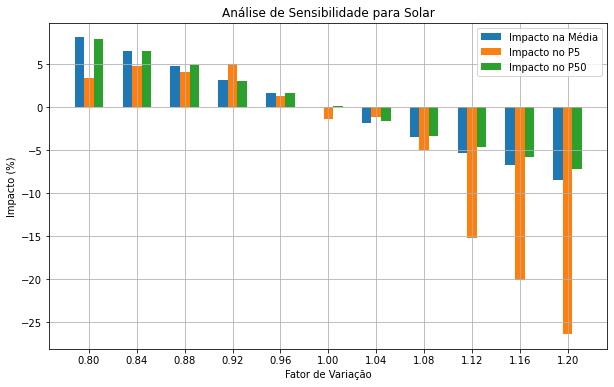

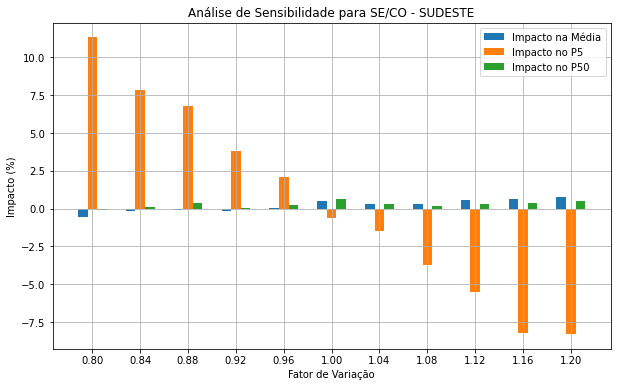

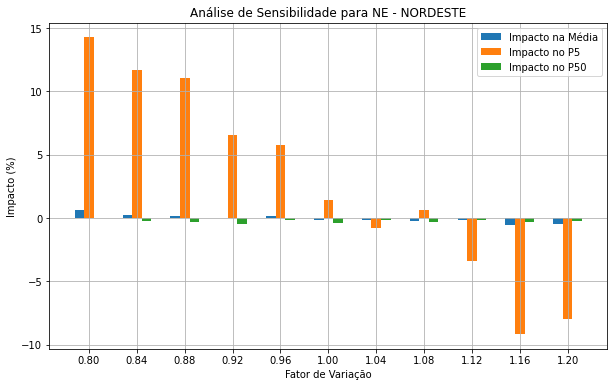

In [37]:
# Função para criar gráficos de sensibilidade com barras
def plot_sensitivity_bar(results, variable_name):
    factors = [result[0] for result in results]
    impact_on_media = [result[1] for result in results]
    impact_on_P5 = [result[2] for result in results]
    impact_on_P50 = [result[3] for result in results]
    
    width = 0.2
    x = np.arange(len(factors))
    
    plt.figure(figsize=(10, 6))
    
    plt.bar(x - width, impact_on_media, width, label='Impacto na Média')
    plt.bar(x, impact_on_P5, width, label='Impacto no P5')
    plt.bar(x + width, impact_on_P50, width, label='Impacto no P50')
    
    plt.xlabel('Fator de Variação')
    plt.ylabel('Impacto (%)')
    plt.title(f'Análise de Sensibilidade para {variable_name}')
    plt.xticks(x, [f"{factor:.2f}" for factor in factors])
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Realizando a análise de sensibilidade e criando os gráficos de barras
for i, variable in enumerate(variaveis):
    sensitivity_results = sensitivity_analysis(df_exposição2, variaveis, i)
    plot_sensitivity_bar(sensitivity_results, variable)
